In [27]:
!pip install tensorflow matplotlib seaborn pandas scikit-learn
#import thư viện
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd
import os


In [28]:
# Đường dẫn dataset
train_dir = "../dataset_splits/train"
validation_dir = "../dataset_splits/validation"
test_dir = "../dataset_splits/test"

# Hyperparameters
image_size = 150
batch_size = 32
epochs = 15       #đổi số epoch để chạy nhiều hơn dùm nha
learning_rate = 1e-3
num_classes = 6
color_mode = 'rgb'  
channels = 3  

In [29]:

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Lưu class names
class_names = list(train_generator.class_indices.keys())

steps_per_epoch = int(np.ceil(train_generator.samples / batch_size))
validation_steps = int(np.ceil(validation_generator.samples / batch_size))
test_steps = int(np.ceil(test_generator.samples / batch_size))

print(f"\nClasses: {list(train_generator.class_indices.keys())}")
print(f"  Mẫu Training:   {train_generator.samples:>5} → {steps_per_epoch:>3} steps")
print(f"  Mẫu Validation: {validation_generator.samples:>5} → {validation_steps:>3} steps")
print(f"  Mẫu Test:       {test_generator.samples:>5} → {test_steps:>3} steps")
print(f"  Input shape:        ({image_size}, {image_size}, {channels})")

Found 7245 images belonging to 6 classes.
Found 1355 images belonging to 6 classes.
Found 448 images belonging to 6 classes.

Classes: ['0', '1', '2', '3', '4', '5']
  Mẫu Training:    7245 → 227 steps
  Mẫu Validation:  1355 →  43 steps
  Mẫu Test:         448 →  14 steps
  Input shape:        (150, 150, 3)


In [30]:
#Xây dựng model
model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', 
                 input_shape=(image_size, image_size, 3), name='conv1'),
    layers.MaxPooling2D((2, 2), name='pool1'),
    
    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', name='conv2'),
    layers.MaxPooling2D((2, 2), name='pool2'),
    
    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', name='conv3'),
    layers.MaxPooling2D((2, 2), name='pool3'),
    
    # Block 4
    layers.Conv2D(256, (3, 3), activation='relu', name='conv4'),
    layers.MaxPooling2D((2, 2), name='pool4'),
    
    # Fully Connected Layers
    layers.Flatten(name='flatten'),
    layers.Dropout(0.6, name='dropout'),
    layers.Dense(256, activation='relu', 
                kernel_regularizer=regularizers.l2(0.002), name='fc1'),
    layers.Dense(num_classes, activation='softmax', name='output')
])

# Hiển thị kiến trúc model
model.summary()

c:\Users\ADMIN\Documents\Tomato-Leaf-Diseases-Image-Classification-Using-Deep-Learning\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,601,478 (13.74 MB)

 Trainable params: 3,601,478 (13.74 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

In [32]:
callbacks = [
    ModelCheckpoint(
        './saved_model/tomato_rgb_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Giảm learning rate khi plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]


In [33]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

# Lưu model cuối cùng
model.save('./saved_model/tomato_rgb_final.h5')

Epoch 1/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.4213 - auc: 0.7616 - loss: 1.7315 - precision: 0.6510 - recall: 0.2141
Epoch 1: val_accuracy improved from None to 0.79852, saving model to ./saved_model/tomato_rgb_best.h5



Epoch 1: finished saving model to ./saved_model/tomato_rgb_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 69s 298ms/step - accuracy: 0.5821 - auc: 0.8787 - loss: 1.2789 - precision: 0.7647 - recall: 0.4239 - val_accuracy: 0.7985 - val_auc: 0.9700 - val_loss: 0.7146 - val_precision: 0.8550 - val_recall: 0.7225 - learning_rate: 0.0010
Epoch 2/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7912 - auc: 0.9657 - loss: 0.7309 - precision: 0.8344 - recall: 0.7367
Epoch 2: val_accuracy improved from 0.79852 to 0.86863, saving model to ./saved_model/tomato_rgb_best.h5



Epoch 2: finished saving model to ./saved_model/tomato_rgb_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 64s 281ms/step - accuracy: 0.7996 - auc: 0.9690 - loss: 0.7045 - precision: 0.8392 - recall: 0.7527 - val_accuracy: 0.8686 - val_auc: 0.9854 - val_loss: 0.5467 - val_precision: 0.8978 - val_recall: 0.8295 - learning_rate: 0.0010
Epoch 3/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.8522 - auc: 0.9834 - loss: 0.5576 - precision: 0.8788 - recall: 0.8258
Epoch 3: val_accuracy improved from 0.86863 to 0.89594, saving model to ./saved_model/tomato_rgb_best.h5



Epoch 3: finished saving model to ./saved_model/tomato_rgb_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 68s 298ms/step - accuracy: 0.8530 - auc: 0.9828 - loss: 0.5637 - precision: 0.8762 - recall: 0.8268 - val_accuracy: 0.8959 - val_auc: 0.9907 - val_loss: 0.4661 - val_precision: 0.9094 - val_recall: 0.8672 - learning_rate: 0.0010
Epoch 4/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.8771 - auc: 0.9882 - loss: 0.4974 - precision: 0.9014 - recall: 0.8591
Epoch 4: val_accuracy improved from 0.89594 to 0.92251, saving model to ./saved_model/tomato_rgb_best.h5



Epoch 4: finished saving model to ./saved_model/tomato_rgb_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 62s 273ms/step - accuracy: 0.8752 - auc: 0.9876 - loss: 0.5041 - precision: 0.8969 - recall: 0.8547 - val_accuracy: 0.9225 - val_auc: 0.9932 - val_loss: 0.4186 - val_precision: 0.9306 - val_recall: 0.9011 - learning_rate: 0.0010
Epoch 5/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.8845 - auc: 0.9897 - loss: 0.4747 - precision: 0.9059 - recall: 0.8701
Epoch 5: val_accuracy improved from 0.92251 to 0.92546, saving model to ./saved_model/tomato_rgb_best.h5



Epoch 5: finished saving model to ./saved_model/tomato_rgb_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 63s 275ms/step - accuracy: 0.8900 - auc: 0.9900 - loss: 0.4669 - precision: 0.9066 - recall: 0.8748 - val_accuracy: 0.9255 - val_auc: 0.9949 - val_loss: 0.3771 - val_precision: 0.9380 - val_recall: 0.9159 - learning_rate: 0.0010
Epoch 6/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9042 - auc: 0.9932 - loss: 0.4117 - precision: 0.9206 - recall: 0.8951
Epoch 6: val_accuracy improved from 0.92546 to 0.93801, saving model to ./saved_model/tomato_rgb_best.h5



Epoch 6: finished saving model to ./saved_model/tomato_rgb_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 62s 274ms/step - accuracy: 0.9100 - auc: 0.9932 - loss: 0.4081 - precision: 0.9235 - recall: 0.9009 - val_accuracy: 0.9380 - val_auc: 0.9970 - val_loss: 0.3291 - val_precision: 0.9489 - val_recall: 0.9328 - learning_rate: 0.0010
Epoch 7/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9254 - auc: 0.9943 - loss: 0.3781 - precision: 0.9350 - recall: 0.9152
Epoch 7: val_accuracy did not improve from 0.93801
227/227 ━━━━━━━━━━━━━━━━━━━━ 63s 278ms/step - accuracy: 0.9161 - auc: 0.9931 - loss: 0.4080 - precision: 0.9283 - recall: 0.9048 - val_accuracy: 0.9240 - val_auc: 0.9938 - val_loss: 0.4063 - val_precision: 0.9329 - val_recall: 0.9129 - learning_rate: 0.0010
Epoch 8/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9182 - auc: 0.9937 - loss: 0.4057 - precision: 0.9273 - recall: 0.9071
Epoch 8: val_accuracy improved from 0.93801 to 0.94760, saving model to ./saved_model/t


Epoch 8: finished saving model to ./saved_model/tomato_rgb_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 62s 272ms/step - accuracy: 0.9246 - auc: 0.9947 - loss: 0.3869 - precision: 0.9333 - recall: 0.9148 - val_accuracy: 0.9476 - val_auc: 0.9980 - val_loss: 0.3068 - val_precision: 0.9517 - val_recall: 0.9446 - learning_rate: 0.0010
Epoch 9/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9354 - auc: 0.9961 - loss: 0.3438 - precision: 0.9437 - recall: 0.9280
Epoch 9: val_accuracy did not improve from 0.94760
227/227 ━━━━━━━━━━━━━━━━━━━━ 63s 278ms/step - accuracy: 0.9350 - auc: 0.9959 - loss: 0.3502 - precision: 0.9445 - recall: 0.9271 - val_accuracy: 0.9351 - val_auc: 0.9960 - val_loss: 0.3581 - val_precision: 0.9424 - val_recall: 0.9292 - learning_rate: 0.0010
Epoch 10/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9418 - auc: 0.9969 - loss: 0.3297 - precision: 0.9474 - recall: 0.9344
Epoch 10: val_accuracy did not improve from 0.94760
227/227 ━━━━━━━━━━━━━━━━━━━━ 64s 2


Epoch 12: finished saving model to ./saved_model/tomato_rgb_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 68s 299ms/step - accuracy: 0.9532 - auc: 0.9975 - loss: 0.3019 - precision: 0.9579 - recall: 0.9473 - val_accuracy: 0.9528 - val_auc: 0.9970 - val_loss: 0.3160 - val_precision: 0.9589 - val_recall: 0.9461 - learning_rate: 0.0010
Epoch 13/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9552 - auc: 0.9975 - loss: 0.2951 - precision: 0.9589 - recall: 0.9511
Epoch 13: val_accuracy did not improve from 0.95277

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 269ms/step - accuracy: 0.9517 - auc: 0.9974 - loss: 0.2992 - precision: 0.9557 - recall: 0.9476 - val_accuracy: 0.9424 - val_auc: 0.9966 - val_loss: 0.3173 - val_precision: 0.9507 - val_recall: 0.9395 - learning_rate: 0.0010
Epoch 14/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9700 - auc: 0.9990 - loss: 0.2424 - precision: 0.9735 - recall: 0.9661
Epoch


Epoch 14: finished saving model to ./saved_model/tomato_rgb_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 62s 273ms/step - accuracy: 0.9754 - auc: 0.9995 - loss: 0.2109 - precision: 0.9779 - recall: 0.9731 - val_accuracy: 0.9668 - val_auc: 0.9989 - val_loss: 0.2107 - val_precision: 0.9697 - val_recall: 0.9668 - learning_rate: 5.0000e-04
Epoch 15/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9784 - auc: 0.9996 - loss: 0.1800 - precision: 0.9805 - recall: 0.9765
Epoch 15: val_accuracy did not improve from 0.96679
227/227 ━━━━━━━━━━━━━━━━━━━━ 67s 296ms/step - accuracy: 0.9786 - auc: 0.9995 - loss: 0.1761 - precision: 0.9809 - recall: 0.9771 - val_accuracy: 0.9668 - val_auc: 0.9985 - val_loss: 0.1952 - val_precision: 0.9689 - val_recall: 0.9668 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 15.


In [34]:
print("Đánh giá trên tập testing")
print("=" * 70)

# Evaluate model với số steps chính xác
test_results = model.evaluate(
    test_generator,
    steps=test_steps,
    verbose=1
)

# Lấy predictions trên toàn bộ tập test
test_generator.reset()
y_pred_probs = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# LẤY ĐÚNG SỐ LƯỢNG TRUE LABELS
y_true = test_generator.classes[:test_generator.samples]

# KIỂM TRA
print(f" Tổng mẫu test:    {test_generator.samples}")
print(f" Dự đoán được tạo: {len(y_pred)}")
print(f" Nhãn đúng được thu thập: {len(y_true)}")

# Đảm bảo cắt đúng số lượng
y_pred = y_pred[:test_generator.samples]
y_true = y_true[:test_generator.samples]

# Tính các metrics
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')

print("\n" + "=" * 70)
print("Metric trên tập test")
print("=" * 70)
print(f"Test Loss:      {test_results[0]:.4f}")
print(f"Test Accuracy:  {test_results[1]*100:.2f}%")
print(f"Test Precision: {test_precision*100:.2f}%")
print(f"Test Recall:    {test_recall*100:.2f}%")
print(f"Test F1-Score:  {test_f1*100:.2f}%")
print(f"Test AUC:       {test_results[4]:.4f}")

Đánh giá trên tập testing
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9777 - auc: 0.9996 - loss: 0.1669 - precision: 0.9843 - recall: 0.9777
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
 Tổng mẫu test:    448
 Dự đoán được tạo: 448
 Nhãn đúng được thu thập: 448

Metric trên tập test
Test Loss:      0.1669
Test Accuracy:  97.77%
Test Precision: 97.86%
Test Recall:    97.77%
Test F1-Score:  97.76%
Test AUC:       0.9996


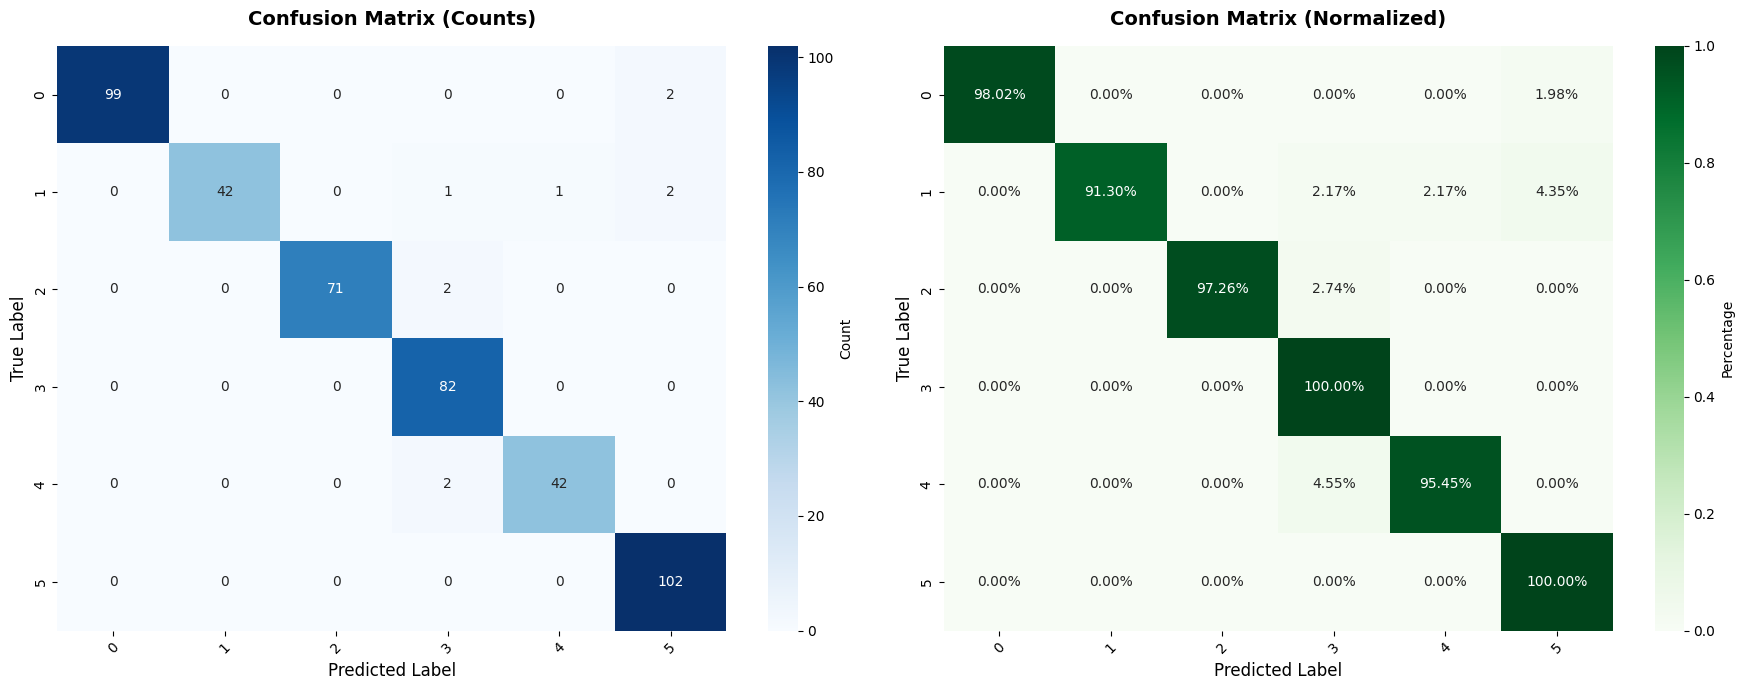

In [35]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Vẽ confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    # Tính accuracy cho từng class
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Confusion Matrix (Count)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cbar_kws={'label': 'Count'},
                ax=ax1)
    ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold', pad=15)
    ax1.set_ylabel('True Label', fontsize=12)
    ax1.set_xlabel('Predicted Label', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # Confusion Matrix (Normalized)
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cbar_kws={'label': 'Percentage'},
                ax=ax2)
    ax2.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold', pad=15)
    ax2.set_ylabel('True Label', fontsize=12)
    ax2.set_xlabel('Predicted Label', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return cm

cm = plot_confusion_matrix(y_true, y_pred, class_names)

In [36]:
print("Classification report")
print("=" * 70)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Tạo DataFrame từ classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("\nBảng metrics theo từng lớp:")
print(df_report.to_string())

Classification report
              precision    recall  f1-score   support

           0     1.0000    0.9802    0.9900       101
           1     1.0000    0.9130    0.9545        46
           2     1.0000    0.9726    0.9861        73
           3     0.9425    1.0000    0.9704        82
           4     0.9767    0.9545    0.9655        44
           5     0.9623    1.0000    0.9808       102

    accuracy                         0.9777       448
   macro avg     0.9803    0.9701    0.9746       448
weighted avg     0.9786    0.9777    0.9776       448


Bảng metrics theo từng lớp:
              precision    recall  f1-score     support
0              1.000000  0.980198  0.990000  101.000000
1              1.000000  0.913043  0.954545   46.000000
2              1.000000  0.972603  0.986111   73.000000
3              0.942529  1.000000  0.970414   82.000000
4              0.976744  0.954545  0.965517   44.000000
5              0.962264  1.000000  0.980769  102.000000
accuracy      

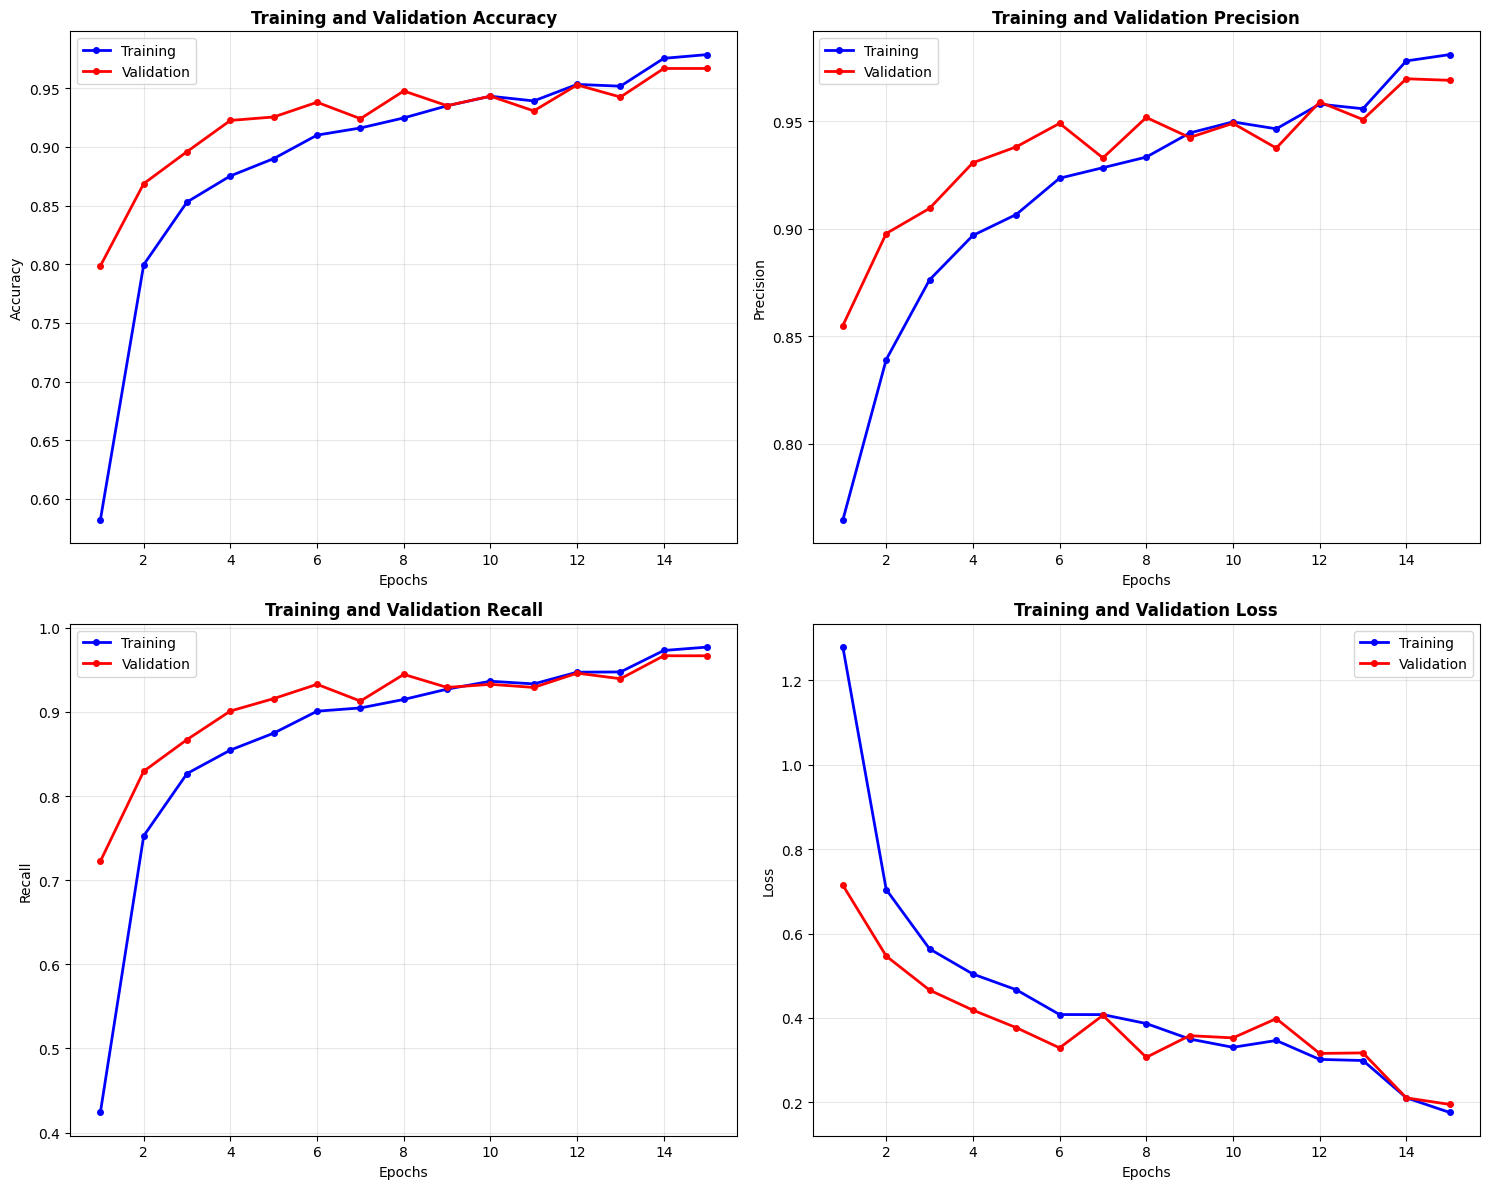


Kết quả training chi tiết
Best Training Accuracy:    97.86%
Best Validation Accuracy:  96.68%
Best Training Precision:   98.09%
Best Validation Precision: 96.97%
Best Training Recall:      97.71%
Best Validation Recall:    96.68%
Final Training Loss:       0.1761
Final Validation Loss:     0.1952


In [37]:
def plot_training_history(history):
    """Vẽ biểu đồ quá trình training với nhiều metrics"""
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'loss']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    epochs_range = range(1, len(history.history['accuracy']) + 1)
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx]
        
        if metric == 'loss':
            train_metric = history.history['loss']
            val_metric = history.history['val_loss']
            title = 'Training and Validation Loss'
            ylabel = 'Loss'
        else:
            train_metric = history.history[metric]
            val_metric = history.history[f'val_{metric}']
            title = f'Training and Validation {metric.capitalize()}'
            ylabel = metric.capitalize()
        
        ax.plot(epochs_range, train_metric, 'bo-', label=f'Training', linewidth=2, markersize=4)
        ax.plot(epochs_range, val_metric, 'ro-', label=f'Validation', linewidth=2, markersize=4)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('Epochs', fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # In thông tin chi tiết
    print("\n" + "=" * 70)
    print("Kết quả training chi tiết")
    print("=" * 70)
    print(f"Best Training Accuracy:    {max(history.history['accuracy'])*100:.2f}%")
    print(f"Best Validation Accuracy:  {max(history.history['val_accuracy'])*100:.2f}%")
    print(f"Best Training Precision:   {max(history.history['precision'])*100:.2f}%")
    print(f"Best Validation Precision: {max(history.history['val_precision'])*100:.2f}%")
    print(f"Best Training Recall:      {max(history.history['recall'])*100:.2f}%")
    print(f"Best Validation Recall:    {max(history.history['val_recall'])*100:.2f}%")
    print(f"Final Training Loss:       {history.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss:     {history.history['val_loss'][-1]:.4f}")

# Vẽ biểu đồ
plot_training_history(history)

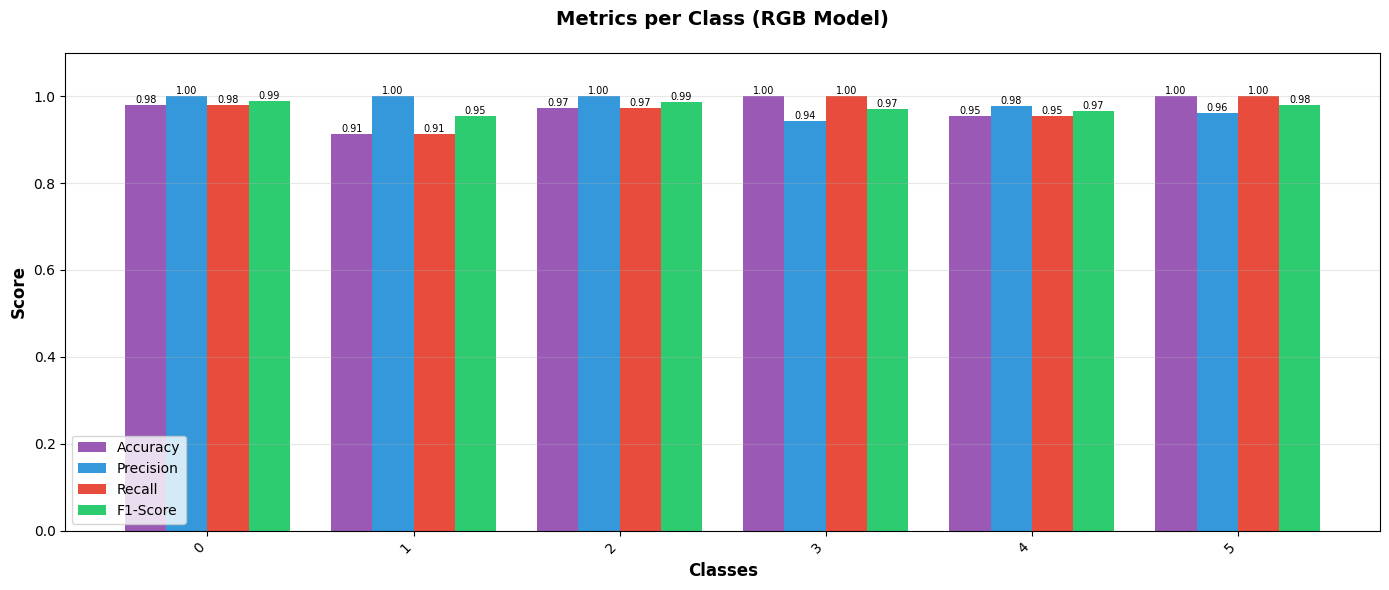


Metrics cho từng lớp
Class  Accuracy  Precision   Recall  F1-Score  Support
    0  0.980198   1.000000 0.980198  0.990000      101
    1  0.913043   1.000000 0.913043  0.954545       46
    2  0.972603   1.000000 0.972603  0.986111       73
    3  1.000000   0.942529 1.000000  0.970414       82
    4  0.954545   0.976744 0.954545  0.965517       44
    5  1.000000   0.962264 1.000000  0.980769      102


In [38]:
def plot_metrics_per_class(y_true, y_pred, class_names):
    """Vẽ biểu đồ metrics cho từng class"""
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    # Tính accuracy per class từ confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
    
    x = np.arange(len(class_names))
    width = 0.2
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    bars1 = ax.bar(x - 1.5*width, accuracy_per_class, width, label='Accuracy', color='#9b59b6')
    bars2 = ax.bar(x - 0.5*width, precision_per_class, width, label='Precision', color='#3498db')
    bars3 = ax.bar(x + 0.5*width, recall_per_class, width, label='Recall', color='#e74c3c')
    bars4 = ax.bar(x + 1.5*width, f1_per_class, width, label='F1-Score', color='#2ecc71')
    
    ax.set_xlabel('Classes', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Metrics per Class (RGB Model)', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.1])
    
    # Thêm giá trị trên các cột
    for bars in [bars1, bars2, bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}',
                   ha='center', va='bottom', fontsize=7)
    
    plt.tight_layout()
    plt.show()
    
    # In bảng chi tiết
    print("\n" + "=" * 70)
    print("Metrics cho từng lớp")
    print("=" * 70)
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Accuracy': accuracy_per_class,
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1-Score': f1_per_class,
        'Support': cm.sum(axis=1)
    })
    print(metrics_df.to_string(index=False))
    
    return metrics_df

metrics_df = plot_metrics_per_class(y_true, y_pred, class_names)


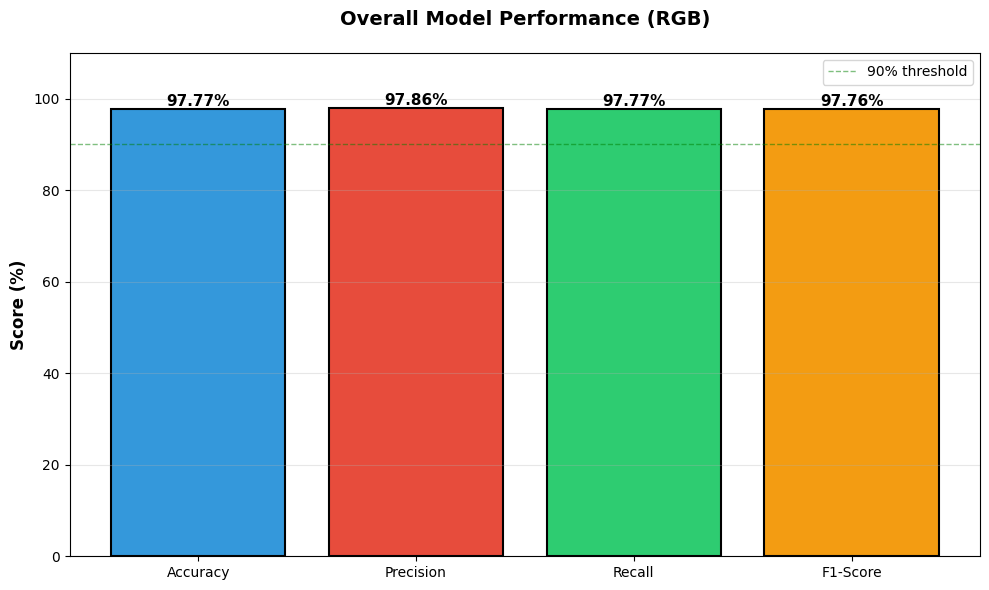

In [39]:
def plot_model_comparison():
    """So sánh các metrics tổng quan"""
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metrics_values = [
        test_results[1] * 100,
        test_precision * 100,
        test_recall * 100,
        test_f1 * 100
    ]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(metrics_names, metrics_values, 
                   color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'],
                   edgecolor='black', linewidth=1.5)
    
    ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
    ax.set_title('Overall Model Performance (RGB)', fontsize=14, fontweight='bold', pad=20)
    ax.set_ylim([0, 110])
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=90, color='green', linestyle='--', linewidth=1, alpha=0.5, label='90% threshold')
    ax.legend()
    
    # Thêm giá trị trên các cột
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2f}%',
               ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

plot_model_comparison()


In [40]:
print("Tổng kết")
print(f"""
\n=================Thông Tin Model===================\n
- Kiến trúc: Custom CNN (4 Conv blocks)
- Input shape: {image_size}x{image_size}x{channels} (RGB)
- Số lớp phân loại: {num_classes}
- Tổng số parameters: {model.count_params():,}

\n=================Thông Tin Tập Dữ Liệu===================\n
- Training samples:   {train_generator.samples:>5} ({steps_per_epoch} steps/epoch)
- Validation samples: {validation_generator.samples:>5} ({validation_steps} steps)
- Test samples:       {test_generator.samples:>5} ({test_steps} steps)
- Classes: {', '.join(class_names)}


\n=================Thông Tin Hyperparameters===================\n
- Learning rate (initial): {learning_rate}
- Batch size: {batch_size}
- Epochs trained: {len(history.history['loss'])} / {epochs}
- Optimizer: Adam
- Loss function: Categorical Crossentropy

\n=================Thông Tin Regularization===================\n
- Dropout: 0.6
- L2 regularization: 0.002
- Early stopping: patience=15
- Learning rate reduction: factor=0.5, patience=5

\n=================Kết Quả Training & Validation===================\n
Training (Final):
  - Accuracy:    {history.history['accuracy'][-1]*100:>6.2f}%
  - Precision:   {history.history['precision'][-1]*100:>6.2f}%
  - Recall:      {history.history['recall'][-1]*100:>6.2f}%
  - Loss:        {history.history['loss'][-1]:>6.4f}

Validation (Final):
  - Accuracy:    {history.history['val_accuracy'][-1]*100:>6.2f}%
  - Precision:   {history.history['val_precision'][-1]*100:>6.2f}%
  - Recall:      {history.history['val_recall'][-1]*100:>6.2f}%
  - Loss:        {history.history['val_loss'][-1]:>6.4f}

Best Validation Metrics:
  - Best Accuracy:  {max(history.history['val_accuracy'])*100:.2f}% (epoch {np.argmax(history.history['val_accuracy'])+1})
  - Best Precision: {max(history.history['val_precision'])*100:.2f}%
  - Best Recall:    {max(history.history['val_recall'])*100:.2f}%

\n=================Kết Quả Trên Tập Test===================\n
- Test Accuracy:  {test_results[1]*100:>6.2f}%
- Test Precision: {test_precision*100:>6.2f}%
- Test Recall:    {test_recall*100:>6.2f}%
- Test F1-Score:  {test_f1*100:>6.2f}%
- Test AUC:       {test_results[4]:>6.4f}
- Test Loss:      {test_results[0]:>6.4f}
""")

Tổng kết


=================Thông Tin Model===================

- Kiến trúc: Custom CNN (4 Conv blocks)
- Input shape: 150x150x3 (RGB)
- Số lớp phân loại: 6
- Tổng số parameters: 3,601,478


=================Thông Tin Tập Dữ Liệu===================

- Training samples:    7245 (227 steps/epoch)
- Validation samples:  1355 (43 steps)
- Test samples:         448 (14 steps)
- Classes: 0, 1, 2, 3, 4, 5



=================Thông Tin Hyperparameters===================

- Learning rate (initial): 0.001
- Batch size: 32
- Epochs trained: 15 / 15
- Optimizer: Adam
- Loss function: Categorical Crossentropy


=================Thông Tin Regularization===================

- Dropout: 0.6
- L2 regularization: 0.002
- Early stopping: patience=15
- Learning rate reduction: factor=0.5, patience=5


=================Kết Quả Training & Validation===================

Training (Final):
  - Accuracy:     97.86%
  - Precision:    98.09%
  - Recall:       97.71%
  - Loss:        0.1761

Validation (Final):
  -

In [41]:
!git remote -v

origin	https://github.com/tano-dev/Tomato-Leaf-Diseases-Image-Classification-Using-Deep-Learning.git (fetch)
origin	https://github.com/tano-dev/Tomato-Leaf-Diseases-Image-Classification-Using-Deep-Learning.git (push)


In [42]:
!git remote set-url origin https://github.com/tano-dev/Tomato-Leaf-Diseases-Image-Classification-Using-Deep-Learning.git


In [43]:
!git remote -v


origin	https://github.com/tano-dev/Tomato-Leaf-Diseases-Image-Classification-Using-Deep-Learning.git (fetch)
origin	https://github.com/tano-dev/Tomato-Leaf-Diseases-Image-Classification-Using-Deep-Learning.git (push)


In [44]:
!git status -sb

## pntv...origin/pntv
 M convNet_1.ipynb
?? saved_model/


In [45]:
!git push -u origin pntv

branch 'pntv' set up to track 'origin/pntv'.


Everything up-to-date
